In [2]:
# Import libary 
import csv
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

import keras
import ast
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, Activation, Dropout
from keras import backend as K
from keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import model_from_json
import re

pd.set_option('display.max_rows', 500) # 많은 데이터를 한눈에 볼 수 있도록

<ipython-input-2-f4b5c4fa3355>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
# ------ 필요 함수

# LSTM을 위함/ 조건을 불러오는 방법, 일반화하기 위함
def get_variables(condition_file_name):
    condition_df = pd.read_csv(condition_file_name,encoding='cp949')
    keys = condition_df['condition_col_name'].tolist()
    values = condition_df['condition'].tolist()
    
    condition_list = get_conditions(keys,values)
    
    return condition_list

def get_conditions(keys,values):
    """
    함수설명
    --------
    조건 컬럼명과 조건 값을 Disctionary 형태로 변경
    > 조건을 한번에 필터 하기 위한 데이터 변경 
    
    parameters
    ----------
    keys(조건 컬럼명)
    values(조건)
    
    return
    ------
    conditions: Dictionary 형태로 조건 컬럼명과 조건 
    """
    values = [tryeval(x) for x in values]
    values2 = [[_] for _ in values]
    conditions = dict(zip(keys, values2))
    return conditions


def tryeval(val): # change str into int in a list 
    try:
        val = ast.literal_eval(val)
    except ValueError:
        pass
    return val


def filter_df(df, filter_values):
    """
    함수설명
    --------
    Filter df by matching targets for multiple columns.
    
    parameters
    ----------
    df: 데이터 셋
    filter_values: Dictionary 형태의 조건 리스트: condition_list (조건 설정 파일에서 불러옴)
    
    return
    ------
    df 조건에 따라 필터된 데이터셋 
    """
        
    if filter_values is None or not filter_values:
        return df
    return df[
        np.logical_and.reduce([
            df[column].isin(target_values) 
            for column, target_values in filter_values.items()
        ])
    ]

def read_data_info (read_data_file, read_col_info_file, read_model_info_file, condition = None): 
    """
    함수설명
    --------
    데이터 파일 읽기, 모델링에 필요한 데이터 유형, 역할, 예측 주기 파라미터 
    값 사용자 지정 파일에서 불러오기 기능 
    
    parameters
    ----------
    read_data_file: 데이터 셋 파일명
    read_col_info_file: 데이터 정보 파일명
    read_model_info_file: 사용될 모델 지정 파일명
    condition = None: 조건값 자체를 사용안될 경우 고려  
        => read_data_info (read_data_file, read_col_info_file, read_model_info_file) 도 작동
    
    return
    ------
    features, 더미화 된 x변수의 columns 이름
    x_val,  사용자가 지정한 x변수
    y_val, predic_period,  사용자가 지정한 y변수(타겟)
    Train,  학습용 데이터
    Predict,  예측용 데이터
    model_name,  사용할 모델
    train_p,  학습용 데이터의 날짜의 총갯수
    test_p  예측용 데이터의 날짜의 총갯수
    
    """
    
    
    # input data
    data = pd.read_csv(read_data_file, index_col=0) #이름이 지정되지 않은 첫 컬럼은 새로 데이터를 만들면서 index가 자동으로 생성되었기에 제거
    data.fillna(0, inplace=True) # RD에 있는 NAN 데이터를 0으로 바꿈 => 데이터 유형을 정수로 표현하기 위해 (데이터 셋 분리과정)

    # input role info
    role_info = pd.read_csv(read_col_info_file, encoding ='cp949') # 모델링 할 때 사용할 x, y, month
    x_val = role_info.loc[role_info['Role']=='x', 'col_name'].tolist() # x변수 다중리스트형태
    y_val = role_info.loc[role_info['Role']=='y', 'col_name'].tolist()[0] # y변수는 단일
    predic_period = role_info.loc[role_info['예측주기']=='P', 'col_name'].tolist()[0]

    # col info
    dummy_list = role_info.loc[role_info['col_info']=='STR', 'col_name'].tolist() 

    # input model info 모델과 예측달 정하기
    model_info = pd.read_csv(read_model_info_file)
    model_name = model_info['Model'][0] # 기본으로 auto_reg 지정

    # 데이터 재구성 : 다변량에서도 잘 작동하는지 확인하기 위해 임의작업 - random한 값
    X_data = data[x_val]
    ele = [x for x in dummy_list if x in X_data]
    dummied_X = pd.get_dummies(data=X_data, columns = ele)
    features = dummied_X.columns
    dummied_df = pd.get_dummies(data=data, columns = ele)
    new_data = np.random.random( size=(len(dummied_df),len(features)))
    new_df = pd.DataFrame(new_data, columns =features , index = dummied_df.index)
    new_generated_df = dummied_df.drop(features,axis=1)
    new_generated_df = pd.concat([new_generated_df,new_df], axis=1)

    # 시계열 형식으로 변환 (datetime)
    new_generated_df[predic_period] = pd.to_datetime(new_generated_df[predic_period], format= '%y-%b') # predic_period를 datetime 으로 변환

    # 조건에 해당하는 set으로 재구성
    new_generated_df = filter_df(new_generated_df, condition) # 필터를 이용해 조건에 해당하는 값으로 df 재구성 # 조건이 없다면 condition없이 작성해도 무방

    # data split
    Train = new_generated_df[new_generated_df['DATA_TYPE']=='TD'] # 학습할 데이터
    Predict = new_generated_df[new_generated_df['DATA_TYPE']=='RD'] # 예측해야할 데이터 

    # 시계열 데이터로 구성하기 위해 필요한 단계 : 기존의 달 수, 예측할 달 수 
    train_p = len(Train[predic_period].unique()) # train의 날짜의 총갯수
    test_p = len(Predict[predic_period].unique()) # predict의 날짜의 총갯수
    
    return features, x_val, y_val, predic_period, new_generated_df, model_name, train_p, test_p

In [4]:
# ----- LSTM을 위한 전처리 & lag 생성
def make_model_df (df,features, y_val, predic_period, train_p, test_p, model_name):
    """
    함수설명
    --------
    LSTM을 위한 전처리 & lag 생성
    
    parameters
    ----------
    df: Input 데이터 셋 
    features : 더미화된 컬럼이름
    y_val: y 컬럼 이름 
    predic_period: 예측 주기 (12= 1년)
    train_p: train의 날짜의 총 갯수
    test_p: predict의 날짜의 총 갯수
    model_name: 단별량, 다변량 구별
    
    return
    ------
    grouped,  조건에 의해 새로 구성한 데이터셋 - 각 월별 평균으로 생성
    x_train,  학습용 데이터 x변수
    y_train,  학습용 데이터 y변수
    x_test,   예측용 데이터 x변수
    y_test,   예측용 데이터 y변수
    scaler: 표준화 된 데이터 값 (Arrary)
  
    """
        
    target = [y_val]
    Nec = [predic_period, y_val]
    features_list = features.tolist()
    
    grouped = df.groupby(predic_period, as_index=False).mean()  # 시간을 기준으로 part들의 qty의 평균으로 데이터 그룹을 만드는 작업
    
    if model_name=='multi_LSTM':
        Nec.extend(features_list)
        grouped = grouped[Nec] # 필요한 컬럼은 시간과 qty + 변수들
    
    elif model_name=='LSTM':
        grouped = grouped[Nec] # 필요한 컬럼은 시간과 qty뿐.
        
    scaler = MinMaxScaler() # MinMaxScaler: 0과 1사이의 값으로 재구성 => 빠른 계산을 위함
    grouped[target] = scaler.fit_transform(grouped[target]) # 위의 scaler방법으로 scaler 시킴
    
    if model_name=='multi_LSTM':
        target.extend(features_list)
        y_hat = grouped[target]
    
    elif model_name=='LSTM':
        y_hat = grouped[target] 
        
    y_hat = np.array(y_hat) 
    x,y = generateX(y_hat,test_p) # lag생성 
    # x= test_p만큼 짤라서 한칸씩 미뤄서 구성, y= y_hat에서 test_p만큼 삭제된 값
    # 위에 구성된 x, y를 재구성
    x = x.reshape(-1,test_p,y_hat.shape[1]) ; y = y.reshape(-1,1) # lstm에 넣기 위한 3차원으로 변환 작업
    
    # 위에서 구성된 x,y를 test_p의 갯수를 이용해 split 
    x_train = x[:(train_p-test_p),:,:] ; y_train = y[:(train_p-test_p),:]
    x_test = x[(train_p-test_p):,:,:] ; y_test = y[(train_p-test_p):,:]
    
    return grouped, x_train, y_train, x_test, y_test, scaler

# make model => lag 생성
def generateX(a, n):
    """
    함수설명
    --------
    시계열에 쓰이는 lag 생성
    : 시계열 자료를 분석할때 관측시점들 간의 시차(time lag) 생성
    
    parameters
    ----------
    a: array 형태
    n: window 사이즈 
    
    return
    ------
    np.array(x_train):  
    np.array(y_train):  lstm 모델에 넣기 위해 array형태로 변환하는 과정
    """
    x_train = []
    y_train = []
    
    for i in range(len(a)):
        x=a[i:(i+n)]
        if(i+n) < len(a):
            x_train.append(x)
            y_train.append(a[i+n])
            
        else:
            break
    return np.array(x_train), np.array(y_train)

In [5]:
# ----- 모델 결과 저장 및 엑셀파일로 내보내기 
# 모델 저장
# 모델 저장
def outputfile(sheet1,output_file_name):     
    sheet1.to_csv(output_file_name, encoding ='utf-8-sig')
    print("\n폴더에서",output_file_name,"파일을 확인하세요")
    
# 결과 값 도출
def get_LSTM_results (model, grouped, y_val, y_train, x_test, scaler, train_p, test_p):
    """
    함수설명
    --------
    1. 모델 정보 파일로 내보내기
    2. 시계열 그래프 
    3. 결과값 Dataframe에 저장 및 엑셀로 내보내기 
    
    parameters
    ----------
    model      : 모델정보
    grouped    : 조건에 의해 만들어진 본래의 데이터셋
    y_val      : 타겟변수 - 예측하고 싶은 것
    y_train    : 기존 시간에 대한 데이터의 추세 - 그림으로 확인하기 위함
    x_test     : 예측값 계산을 위해 만든 예측용 데이터 x
    scaler     : 표준화 된 데이터 값 _ 다시 되돌려 본래의 값으로 출력하기 위해 불러옴
    train_p    : train의 날짜의 총 갯수
    test_p     : predict의 날짜의 총 갯수
    
    return
    ------
    Model_ver: 모델 버젼 (Dataframe 형태)
    grouped: 과거 y 데이터와 예측값 y (Dataframe 형태)
    """
    
    Model_ver = pd.DataFrame([str(model)], columns=['모델정보'])
    filename = re.sub('[<>.]','',str(model).split()[3]) # 생성된 모델정보의 숫자,문자 형태를 파일 이름으로 지정
    model_file1 = "{model}.json".format(model=filename) 
    model_file2 = "{model}.h5".format(model=filename)
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_file1, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_file2)

    prediction = model.predict(x_test, batch_size=1) # 예측값
    
    # 결과 plot line graph 생성 
    a_axis = np.arange(0,len(y_train))
    b_axis = np.arange(len(y_train), len(y_train) + len(prediction))
    plt.figure(figsize=(10,6))
    plt.plot(a_axis, y_train.reshape((train_p-test_p),), 'o-')
    plt.plot(b_axis, prediction.reshape(test_p,), 'o-', color='red', label='Predicted')
    #plt.plot(b_axis, y_test1.reshape(5,), 'o-', color='green', alpha=0.2, label='Actual') # 과거데이터를 나눠서 학습할때 테스트용 
    plt.legend()
    plt.show()
    
    # pred나온 값을 원래의 데이터에 다시 배치
    grouped[y_val][(-test_p):] = sum(prediction.tolist(), [])
    # scaler된 값 복구
    grouped[[y_val]] = scaler.inverse_transform(grouped[[y_val]]) 
    
    outputfile(Model_ver, output_file_name1)
    outputfile(grouped, output_file_name2)
        
    return Model_ver, grouped


# ----- 모델을 파일로 내보내기 및 저장 
def load_model_lstm(jsonfile, h5file, new_RD, grouped, y_val, test_p):
    """
    함수설명
    ________
    json, h5 파일 형태로 저장된 시계열 모델 불러오기 
    
    
    Parameters
    __________
    jsonfile, 
    h5file,
    new_RD,    새로 예측할 데이터
    grouped,   새로 예측할 데이터를 조건에 의한 데이터셋으로 구성
    y_val,     타겟변수
    test_p     예측할 월의 갯수
    
    
    return
    ______
    grouped   조건에 의해 구성한 데이터셋에 예측값을 넣어 한번에 출력
        
    """
   
    json_file = open(jsonfile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(h5file)
    loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    
    pred = loaded_model.predict(new_RD, batch_size=1) # 예측값구하는 식
    
    grouped[y_val][(-test_p):] = sum(pred.tolist(), [])
    # scaler된 값을 다시 원래의 값으로 되돌림
    grouped[[y_val]] = scaler.inverse_transform(grouped[[y_val]])

    outputfile(grouped, output_file_name)
    
    return grouped

# 1. 시계열 딥러닝 (LSTM: Long-short Term Memory)


최근 데이터 예측 방법으로 인공신경망(Artificial Neural Network, ANN)분야에 대한 관심이 높아졌으며, 
그 중 시계열 데이터 예측에 특화된 **LSTM(Long Short-Term Memory)모형**은 수문 시계열자료의 예측방법으로도 활용되고 있다.

http://elearning.kocw.net/contents4/document/lec/2013/Konkuk/Leegiseong/5.pdf
시계열 정보 참고

 - 1.1 단변량 (just y)
 - 1.2 다변량 (related with X)
 
 
 
※ 설정옵션 파일이름 변경으로 단변량, 다변량 테스트
- input_AutoML_설정옵션5.csv *단별량 (LSTM)*
- input_AutoML_설정옵션6.csv *다별량 (Multi_Lstm)*

In [6]:
# Read data & data preparation
read_data_file = 'daesang.csv' # 총 TD:60, RD:5개의 시간이 있는 데이터. 즉, 결측값이 없는 데이터로 재구성
read_col_info_file = 'input_LSTM_데이터유형.csv' # 시계열로 변환이 필요한 예측주기는 일반회귀에선 사용 안함.
read_condition_file = 'input_LSTM_조건설정값3.csv' # part별

In [7]:
# model select
def main():
       
    condition = get_variables(read_condition_file) # 조건값
    features, x_val, y_val, predic_period, new_generated_df, model_name, train_p, test_p = read_data_info (read_data_file, read_col_info_file, read_model_info_file, condition)
    
    grouped, x_train, y_train, x_test, y_test, scaler = make_model_df (new_generated_df, features, y_val, predic_period, train_p, test_p, model_name)
  
    if model_name == 'LSTM' or model_name == 'multi_LSTM':
        # model
        xInput = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))  # input
        xLstm_1 = LSTM(10, return_sequences = True)(xInput)  # lstm 모델 기법
        xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)   #  정확도 향상을 위한 양방향 rnn사용
        xOutput = Dense(1)(xLstm_2) # output

        model = Model(xInput, xOutput) 
        model.compile(loss='mse', optimizer='adam')

        # loss값 계산하며 파일 저장
        basename = "model.h5" # 중간중간 저장함으로 추후 코드끊겼을 때 유용
        suffix = pd.datetime.now().strftime("%y%m%d_%H%M%S") # 파일이 돌아가기 시작한 시간을 기준으로 이름 생성
        path_checkpoint = "_".join([suffix, basename])
        es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=1000) #1000번동안 loss가 변함없다면 stop

        # callback 함수 : #1000번동안 loss가 변함없다면 stop 모델 체크하면서
        modelckpt_callback = keras.callbacks.ModelCheckpoint(
            monitor="loss",
            filepath=path_checkpoint,
            verbose=1,
            save_weights_only=True,
            save_best_only=True,
            mode='auto'
        )

        model.fit(
            x_train, y_train,
            epochs=100000, batch_size=20,
            callbacks=[es_callback, modelckpt_callback],
        )

        get_LSTM_results (model, grouped, y_val, y_train, x_test, scaler, train_p, test_p)
        
    else: 
        print('Please select your data model')

In [8]:
# PART 별 시계열 예측 
if __name__ == "__main__":  
    read_model_info_file = 'input_AutoML_설정옵션5.csv' # 단변량
    output_file_name1 = 'output_단변량_모델.csv'
    output_file_name2 = 'output_단변량_예측값.csv'
    main()

<ipython-input-7-e0dfd1bcddac>:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  suffix = pd.datetime.now().strftime("%y%m%d_%H%M%S") # 파일이 돌아가기 시작한 시간을 기준으로 이름 생성


Epoch 1/100000
3/3 [==============================] - 4s 4ms/step - loss: 0.1430

Epoch 00001: loss improved from inf to 0.12571, saving model to 210324_163420_model.h5
Epoch 2/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.1032

Epoch 00002: loss improved from 0.12571 to 0.10533, saving model to 210324_163420_model.h5
Epoch 3/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0744

Epoch 00003: loss improved from 0.10533 to 0.08711, saving model to 210324_163420_model.h5
Epoch 4/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0671

Epoch 00004: loss improved from 0.08711 to 0.07206, saving model to 210324_163420_model.h5
Epoch 5/100000
3/3 [==============================] - 0s 6ms/step - loss: 0.0554

Epoch 00005: loss improved from 0.07206 to 0.05868, saving model to 210324_163420_model.h5
Epoch 6/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0402

Epoch 00006: loss improved from 0.05868 to 0.04679, savin

Epoch 50/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0204

Epoch 00050: loss improved from 0.01634 to 0.01629, saving model to 210324_163420_model.h5
Epoch 51/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0142

Epoch 00051: loss improved from 0.01629 to 0.01624, saving model to 210324_163420_model.h5
Epoch 52/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0136

Epoch 00052: loss improved from 0.01624 to 0.01619, saving model to 210324_163420_model.h5
Epoch 53/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0127

Epoch 00053: loss improved from 0.01619 to 0.01617, saving model to 210324_163420_model.h5
Epoch 54/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0210

Epoch 00054: loss improved from 0.01617 to 0.01615, saving model to 210324_163420_model.h5
Epoch 55/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0155

Epoch 00055: loss improved from 0.01615 to 0.01

3/3 [==============================] - 0s 4ms/step - loss: 0.0193

Epoch 00102: loss did not improve from 0.01533
Epoch 103/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0155

Epoch 00103: loss improved from 0.01533 to 0.01531, saving model to 210324_163420_model.h5
Epoch 104/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0199

Epoch 00104: loss improved from 0.01531 to 0.01530, saving model to 210324_163420_model.h5
Epoch 105/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0195

Epoch 00105: loss did not improve from 0.01530
Epoch 106/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 00106: loss did not improve from 0.01530
Epoch 107/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0131

Epoch 00107: loss did not improve from 0.01530
Epoch 108/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 00108: loss did not improve from 0.01530
Epoch 109/10

3/3 [==============================] - 0s 4ms/step - loss: 0.0143

Epoch 00162: loss improved from 0.01523 to 0.01523, saving model to 210324_163420_model.h5
Epoch 163/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0144

Epoch 00163: loss did not improve from 0.01523
Epoch 164/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0104

Epoch 00164: loss did not improve from 0.01523
Epoch 165/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0142

Epoch 00165: loss did not improve from 0.01523
Epoch 166/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0211

Epoch 00166: loss did not improve from 0.01523
Epoch 167/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0125

Epoch 00167: loss did not improve from 0.01523
Epoch 168/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0190

Epoch 00168: loss improved from 0.01523 to 0.01523, saving model to 210324_163420_model.h5
Epoch 169/10

3/3 [==============================] - 0s 3ms/step - loss: 0.0198

Epoch 00222: loss did not improve from 0.01516
Epoch 223/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0195

Epoch 00223: loss did not improve from 0.01516
Epoch 224/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0121

Epoch 00224: loss did not improve from 0.01516
Epoch 225/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0104

Epoch 00225: loss improved from 0.01516 to 0.01514, saving model to 210324_163420_model.h5
Epoch 226/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0188

Epoch 00226: loss did not improve from 0.01514
Epoch 227/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0119

Epoch 00227: loss did not improve from 0.01514
Epoch 228/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0128

Epoch 00228: loss did not improve from 0.01514
Epoch 229/100000
3/3 [==============================] - 

3/3 [==============================] - 0s 3ms/step - loss: 0.0135

Epoch 00282: loss did not improve from 0.01507
Epoch 283/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0119

Epoch 00283: loss did not improve from 0.01507
Epoch 284/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0131

Epoch 00284: loss did not improve from 0.01507
Epoch 285/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0106

Epoch 00285: loss did not improve from 0.01507
Epoch 286/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0193

Epoch 00286: loss did not improve from 0.01507
Epoch 287/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0150

Epoch 00287: loss did not improve from 0.01507
Epoch 288/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0144

Epoch 00288: loss did not improve from 0.01507
Epoch 289/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0190

Epoch 00289: los

3/3 [==============================] - 0s 3ms/step - loss: 0.0109

Epoch 00341: loss did not improve from 0.01499
Epoch 342/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0192

Epoch 00342: loss did not improve from 0.01499
Epoch 343/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0195

Epoch 00343: loss did not improve from 0.01499
Epoch 344/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0100

Epoch 00344: loss did not improve from 0.01499
Epoch 345/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0134

Epoch 00345: loss did not improve from 0.01499
Epoch 346/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0142

Epoch 00346: loss improved from 0.01499 to 0.01499, saving model to 210324_163420_model.h5
Epoch 347/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0120

Epoch 00347: loss did not improve from 0.01499
Epoch 348/100000
3/3 [==============================] - 

3/3 [==============================] - 0s 3ms/step - loss: 0.0106

Epoch 00401: loss did not improve from 0.01490
Epoch 402/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0189

Epoch 00402: loss did not improve from 0.01490
Epoch 403/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0132

Epoch 00403: loss did not improve from 0.01490
Epoch 404/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0131

Epoch 00404: loss did not improve from 0.01490
Epoch 405/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0191

Epoch 00405: loss did not improve from 0.01490
Epoch 406/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0182

Epoch 00406: loss did not improve from 0.01490
Epoch 407/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0118

Epoch 00407: loss did not improve from 0.01490
Epoch 408/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0113

Epoch 00408: los

3/3 [==============================] - 0s 4ms/step - loss: 0.0183

Epoch 00460: loss did not improve from 0.01475
Epoch 461/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0189

Epoch 00461: loss did not improve from 0.01475
Epoch 462/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0120

Epoch 00462: loss did not improve from 0.01475
Epoch 463/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0138

Epoch 00463: loss did not improve from 0.01475
Epoch 464/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0118

Epoch 00464: loss did not improve from 0.01475
Epoch 465/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 00465: loss did not improve from 0.01475
Epoch 466/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0109

Epoch 00466: loss did not improve from 0.01475
Epoch 467/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0112

Epoch 00467: los

3/3 [==============================] - 0s 3ms/step - loss: 0.0190

Epoch 00522: loss did not improve from 0.01464
Epoch 523/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0136

Epoch 00523: loss did not improve from 0.01464
Epoch 524/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0180

Epoch 00524: loss did not improve from 0.01464
Epoch 525/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0193

Epoch 00525: loss did not improve from 0.01464
Epoch 526/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0190

Epoch 00526: loss did not improve from 0.01464
Epoch 527/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0121

Epoch 00527: loss did not improve from 0.01464
Epoch 528/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0176

Epoch 00528: loss did not improve from 0.01464
Epoch 529/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0196

Epoch 00529: los

3/3 [==============================] - 0s 3ms/step - loss: 0.0109

Epoch 00582: loss did not improve from 0.01457
Epoch 583/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0182

Epoch 00583: loss did not improve from 0.01457
Epoch 584/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0118

Epoch 00584: loss did not improve from 0.01457
Epoch 585/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0195

Epoch 00585: loss did not improve from 0.01457
Epoch 586/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0123

Epoch 00586: loss improved from 0.01457 to 0.01454, saving model to 210324_163420_model.h5
Epoch 587/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0108

Epoch 00587: loss did not improve from 0.01454
Epoch 588/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0123

Epoch 00588: loss did not improve from 0.01454
Epoch 589/100000
3/3 [==============================] - 

3/3 [==============================] - 0s 4ms/step - loss: 0.0177

Epoch 00642: loss did not improve from 0.01439
Epoch 643/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0176

Epoch 00643: loss did not improve from 0.01439
Epoch 644/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0176

Epoch 00644: loss improved from 0.01439 to 0.01439, saving model to 210324_163420_model.h5
Epoch 645/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0133

Epoch 00645: loss did not improve from 0.01439
Epoch 646/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 00646: loss did not improve from 0.01439
Epoch 647/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0138

Epoch 00647: loss did not improve from 0.01439
Epoch 648/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0124

Epoch 00648: loss improved from 0.01439 to 0.01437, saving model to 210324_163420_model.h5
Epoch 649/10

3/3 [==============================] - 0s 4ms/step - loss: 0.0104

Epoch 00702: loss did not improve from 0.01423
Epoch 703/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0127

Epoch 00703: loss did not improve from 0.01423
Epoch 704/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0174

Epoch 00704: loss did not improve from 0.01423
Epoch 705/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0097

Epoch 00705: loss did not improve from 0.01423
Epoch 706/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0130

Epoch 00706: loss improved from 0.01423 to 0.01421, saving model to 210324_163420_model.h5
Epoch 707/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0094

Epoch 00707: loss did not improve from 0.01421
Epoch 708/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 00708: loss did not improve from 0.01421
Epoch 709/100000
3/3 [==============================] - 

3/3 [==============================] - 0s 3ms/step - loss: 0.0134

Epoch 00760: loss did not improve from 0.01400
Epoch 761/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0186

Epoch 00761: loss did not improve from 0.01400
Epoch 762/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0134

Epoch 00762: loss did not improve from 0.01400
Epoch 763/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0127

Epoch 00763: loss improved from 0.01400 to 0.01399, saving model to 210324_163420_model.h5
Epoch 764/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0145

Epoch 00764: loss did not improve from 0.01399
Epoch 765/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0179

Epoch 00765: loss improved from 0.01399 to 0.01397, saving model to 210324_163420_model.h5
Epoch 766/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0118

Epoch 00766: loss did not improve from 0.01397
Epoch 767/10

3/3 [==============================] - 0s 3ms/step - loss: 0.0133

Epoch 00820: loss did not improve from 0.01378
Epoch 821/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0105

Epoch 00821: loss did not improve from 0.01378
Epoch 822/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0181

Epoch 00822: loss did not improve from 0.01378
Epoch 823/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0131

Epoch 00823: loss did not improve from 0.01378
Epoch 824/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0168

Epoch 00824: loss did not improve from 0.01378
Epoch 825/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0171

Epoch 00825: loss did not improve from 0.01378
Epoch 826/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0121

Epoch 00826: loss did not improve from 0.01378
Epoch 827/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0096

Epoch 00827: los

3/3 [==============================] - 0s 3ms/step - loss: 0.0178

Epoch 00881: loss did not improve from 0.01349
Epoch 882/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0180

Epoch 00882: loss did not improve from 0.01349
Epoch 883/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 00883: loss did not improve from 0.01349
Epoch 884/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0098

Epoch 00884: loss did not improve from 0.01349
Epoch 885/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0183

Epoch 00885: loss did not improve from 0.01349
Epoch 886/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0093

Epoch 00886: loss did not improve from 0.01349
Epoch 887/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0132

Epoch 00887: loss did not improve from 0.01349
Epoch 888/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0095

Epoch 00888: los

3/3 [==============================] - 0s 3ms/step - loss: 0.0124

Epoch 00942: loss did not improve from 0.01318
Epoch 943/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0093

Epoch 00943: loss did not improve from 0.01318
Epoch 944/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0100

Epoch 00944: loss did not improve from 0.01318
Epoch 945/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0163

Epoch 00945: loss did not improve from 0.01318
Epoch 946/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0172

Epoch 00946: loss did not improve from 0.01318
Epoch 947/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0122

Epoch 00947: loss did not improve from 0.01318
Epoch 948/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0168

Epoch 00948: loss did not improve from 0.01318
Epoch 949/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0114

Epoch 00949: los

3/3 [==============================] - 0s 4ms/step - loss: 0.0092

Epoch 01002: loss did not improve from 0.01289
Epoch 1003/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0123

Epoch 01003: loss did not improve from 0.01289
Epoch 1004/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0096

Epoch 01004: loss did not improve from 0.01289
Epoch 1005/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0096

Epoch 01005: loss did not improve from 0.01289
Epoch 1006/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0100

Epoch 01006: loss did not improve from 0.01289
Epoch 1007/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0096

Epoch 01007: loss did not improve from 0.01289
Epoch 1008/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0104

Epoch 01008: loss did not improve from 0.01289
Epoch 1009/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0169

Epoch 010

3/3 [==============================] - 0s 4ms/step - loss: 0.0161

Epoch 01061: loss did not improve from 0.01244
Epoch 1062/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0115

Epoch 01062: loss did not improve from 0.01244
Epoch 1063/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0161

Epoch 01063: loss did not improve from 0.01244
Epoch 1064/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0169

Epoch 01064: loss did not improve from 0.01244
Epoch 1065/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0116

Epoch 01065: loss did not improve from 0.01244
Epoch 1066/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0158

Epoch 01066: loss did not improve from 0.01244
Epoch 1067/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0093

Epoch 01067: loss did not improve from 0.01244
Epoch 1068/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0092

Epoch 010

3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 01120: loss did not improve from 0.01213
Epoch 1121/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0160

Epoch 01121: loss did not improve from 0.01213
Epoch 1122/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0116

Epoch 01122: loss did not improve from 0.01213
Epoch 1123/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0159

Epoch 01123: loss did not improve from 0.01213
Epoch 1124/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 01124: loss did not improve from 0.01213
Epoch 1125/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0160

Epoch 01125: loss did not improve from 0.01213
Epoch 1126/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0110

Epoch 01126: loss did not improve from 0.01213
Epoch 1127/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0090

Epoch 011

Epoch 1180/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0150

Epoch 01180: loss did not improve from 0.01187
Epoch 1181/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0144

Epoch 01181: loss did not improve from 0.01187
Epoch 1182/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 01182: loss did not improve from 0.01187
Epoch 1183/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0107

Epoch 01183: loss did not improve from 0.01187
Epoch 1184/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0112

Epoch 01184: loss did not improve from 0.01187
Epoch 1185/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0150

Epoch 01185: loss improved from 0.01187 to 0.01182, saving model to 210324_163420_model.h5
Epoch 1186/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0106

Epoch 01186: loss did not improve from 0.01182
Epoch 1187/100000
3/3 [=========

3/3 [==============================] - 0s 3ms/step - loss: 0.0109

Epoch 01241: loss did not improve from 0.01161
Epoch 1242/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0162

Epoch 01242: loss did not improve from 0.01161
Epoch 1243/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0147

Epoch 01243: loss did not improve from 0.01161
Epoch 1244/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0160

Epoch 01244: loss did not improve from 0.01161
Epoch 1245/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0155

Epoch 01245: loss did not improve from 0.01161
Epoch 1246/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0092

Epoch 01246: loss did not improve from 0.01161
Epoch 1247/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0118

Epoch 01247: loss did not improve from 0.01161
Epoch 1248/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0155

Epoch 012

3/3 [==============================] - 0s 3ms/step - loss: 0.0084

Epoch 01303: loss did not improve from 0.01154
Epoch 1304/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0158

Epoch 01304: loss did not improve from 0.01154
Epoch 1305/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0149

Epoch 01305: loss did not improve from 0.01154
Epoch 1306/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0090

Epoch 01306: loss did not improve from 0.01154
Epoch 1307/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0152

Epoch 01307: loss did not improve from 0.01154
Epoch 1308/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0151

Epoch 01308: loss did not improve from 0.01154
Epoch 1309/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0086

Epoch 01309: loss did not improve from 0.01154
Epoch 1310/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0117

Epoch 013

3/3 [==============================] - 0s 3ms/step - loss: 0.0114

Epoch 01365: loss did not improve from 0.01126
Epoch 1366/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0090

Epoch 01366: loss did not improve from 0.01126
Epoch 1367/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0115

Epoch 01367: loss did not improve from 0.01126
Epoch 1368/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0155

Epoch 01368: loss did not improve from 0.01126
Epoch 1369/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0087

Epoch 01369: loss did not improve from 0.01126
Epoch 1370/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0158

Epoch 01370: loss did not improve from 0.01126
Epoch 1371/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0153

Epoch 01371: loss did not improve from 0.01126
Epoch 1372/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0087

Epoch 013

3/3 [==============================] - 0s 3ms/step - loss: 0.0100

Epoch 01427: loss did not improve from 0.01126
Epoch 1428/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0104

Epoch 01428: loss did not improve from 0.01126
Epoch 1429/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0113

Epoch 01429: loss did not improve from 0.01126
Epoch 1430/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0149

Epoch 01430: loss did not improve from 0.01126
Epoch 1431/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0151

Epoch 01431: loss did not improve from 0.01126
Epoch 1432/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0104

Epoch 01432: loss did not improve from 0.01126
Epoch 1433/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0085

Epoch 01433: loss did not improve from 0.01126
Epoch 1434/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0082

Epoch 014

3/3 [==============================] - 0s 4ms/step - loss: 0.0115

Epoch 01489: loss did not improve from 0.01126
Epoch 1490/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0149

Epoch 01490: loss did not improve from 0.01126
Epoch 1491/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0114

Epoch 01491: loss did not improve from 0.01126
Epoch 1492/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0106

Epoch 01492: loss did not improve from 0.01126
Epoch 1493/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0107

Epoch 01493: loss did not improve from 0.01126
Epoch 1494/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0156

Epoch 01494: loss did not improve from 0.01126
Epoch 1495/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0148

Epoch 01495: loss did not improve from 0.01126
Epoch 1496/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0149

Epoch 014

3/3 [==============================] - 0s 3ms/step - loss: 0.0106

Epoch 01551: loss did not improve from 0.01126
Epoch 1552/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 01552: loss did not improve from 0.01126
Epoch 1553/100000
3/3 [==============================] - ETA: 0s - loss: 0.004 - 0s 3ms/step - loss: 0.0101

Epoch 01553: loss did not improve from 0.01126
Epoch 1554/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0152

Epoch 01554: loss did not improve from 0.01126
Epoch 1555/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0109

Epoch 01555: loss did not improve from 0.01126
Epoch 1556/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0115

Epoch 01556: loss did not improve from 0.01126
Epoch 1557/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0084

Epoch 01557: loss did not improve from 0.01126
Epoch 1558/100000
3/3 [==============================] - 0s 3ms/step -

3/3 [==============================] - 0s 3ms/step - loss: 0.0151

Epoch 01613: loss did not improve from 0.01126
Epoch 1614/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0084

Epoch 01614: loss did not improve from 0.01126
Epoch 1615/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0105

Epoch 01615: loss did not improve from 0.01126
Epoch 1616/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 01616: loss did not improve from 0.01126
Epoch 1617/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0108

Epoch 01617: loss did not improve from 0.01126
Epoch 1618/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0103

Epoch 01618: loss did not improve from 0.01126
Epoch 1619/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0105

Epoch 01619: loss did not improve from 0.01126
Epoch 1620/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 016

3/3 [==============================] - 0s 5ms/step - loss: 0.0110

Epoch 01675: loss did not improve from 0.01124
Epoch 1676/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0081

Epoch 01676: loss did not improve from 0.01124
Epoch 1677/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0142

Epoch 01677: loss did not improve from 0.01124
Epoch 1678/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0085

Epoch 01678: loss did not improve from 0.01124
Epoch 1679/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0101

Epoch 01679: loss did not improve from 0.01124
Epoch 1680/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0154

Epoch 01680: loss did not improve from 0.01124
Epoch 1681/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0152

Epoch 01681: loss did not improve from 0.01124
Epoch 1682/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 016

3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 01737: loss did not improve from 0.01119
Epoch 1738/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0083

Epoch 01738: loss did not improve from 0.01119
Epoch 1739/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 01739: loss did not improve from 0.01119
Epoch 1740/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 01740: loss did not improve from 0.01119
Epoch 1741/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0108

Epoch 01741: loss did not improve from 0.01119
Epoch 1742/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0146

Epoch 01742: loss did not improve from 0.01119
Epoch 1743/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0104

Epoch 01743: loss did not improve from 0.01119
Epoch 1744/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0154

Epoch 017

Epoch 1799/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0156

Epoch 01799: loss did not improve from 0.01113
Epoch 1800/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0145

Epoch 01800: loss did not improve from 0.01113
Epoch 1801/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 01801: loss did not improve from 0.01113
Epoch 1802/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0155

Epoch 01802: loss did not improve from 0.01113
Epoch 1803/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 01803: loss did not improve from 0.01113
Epoch 1804/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0107

Epoch 01804: loss did not improve from 0.01113
Epoch 1805/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0143

Epoch 01805: loss did not improve from 0.01113
Epoch 1806/100000
3/3 [==============================] - 0s 4ms/step - loss:

3/3 [==============================] - 0s 3ms/step - loss: 0.0143

Epoch 01861: loss did not improve from 0.01113
Epoch 1862/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0141

Epoch 01862: loss did not improve from 0.01113
Epoch 1863/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0084

Epoch 01863: loss did not improve from 0.01113
Epoch 1864/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0078

Epoch 01864: loss did not improve from 0.01113
Epoch 1865/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0080

Epoch 01865: loss did not improve from 0.01113
Epoch 1866/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0086

Epoch 01866: loss did not improve from 0.01113
Epoch 1867/100000
3/3 [==============================] - ETA: 0s - loss: 0.023 - 0s 3ms/step - loss: 0.0152

Epoch 01867: loss did not improve from 0.01113
Epoch 1868/100000
3/3 [==============================] - 0s 4ms/step -

3/3 [==============================] - 0s 4ms/step - loss: 0.0142

Epoch 01922: loss did not improve from 0.01111
Epoch 1923/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0148

Epoch 01923: loss did not improve from 0.01111
Epoch 1924/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0105

Epoch 01924: loss did not improve from 0.01111
Epoch 1925/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0146

Epoch 01925: loss did not improve from 0.01111
Epoch 1926/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0085

Epoch 01926: loss did not improve from 0.01111
Epoch 1927/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0145

Epoch 01927: loss did not improve from 0.01111
Epoch 1928/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0099

Epoch 01928: loss did not improve from 0.01111
Epoch 1929/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0098

Epoch 019

3/3 [==============================] - 0s 3ms/step - loss: 0.0080

Epoch 01984: loss did not improve from 0.01111
Epoch 1985/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0146

Epoch 01985: loss did not improve from 0.01111
Epoch 1986/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0106

Epoch 01986: loss did not improve from 0.01111
Epoch 1987/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0146

Epoch 01987: loss did not improve from 0.01111
Epoch 1988/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0099

Epoch 01988: loss did not improve from 0.01111
Epoch 1989/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 01989: loss did not improve from 0.01111
Epoch 1990/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0143

Epoch 01990: loss did not improve from 0.01111
Epoch 1991/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0081

Epoch 019

3/3 [==============================] - 0s 3ms/step - loss: 0.0145

Epoch 02046: loss did not improve from 0.01103
Epoch 2047/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 02047: loss did not improve from 0.01103
Epoch 2048/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0078

Epoch 02048: loss did not improve from 0.01103
Epoch 2049/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0096

Epoch 02049: loss did not improve from 0.01103
Epoch 2050/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0149

Epoch 02050: loss did not improve from 0.01103
Epoch 2051/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0151

Epoch 02051: loss did not improve from 0.01103
Epoch 2052/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 02052: loss did not improve from 0.01103
Epoch 2053/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 020

3/3 [==============================] - 0s 3ms/step - loss: 0.0081

Epoch 02108: loss did not improve from 0.01103
Epoch 2109/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0077

Epoch 02109: loss did not improve from 0.01103
Epoch 2110/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0144

Epoch 02110: loss did not improve from 0.01103
Epoch 2111/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0101

Epoch 02111: loss did not improve from 0.01103
Epoch 2112/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 02112: loss did not improve from 0.01103
Epoch 2113/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0080

Epoch 02113: loss did not improve from 0.01103
Epoch 2114/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0100

Epoch 02114: loss did not improve from 0.01103
Epoch 2115/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0101

Epoch 021

3/3 [==============================] - 0s 4ms/step - loss: 0.0086

Epoch 02170: loss did not improve from 0.01103
Epoch 2171/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 02171: loss did not improve from 0.01103
Epoch 2172/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 02172: loss did not improve from 0.01103
Epoch 2173/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0149

Epoch 02173: loss did not improve from 0.01103
Epoch 2174/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0148

Epoch 02174: loss improved from 0.01103 to 0.01103, saving model to 210324_163420_model.h5
Epoch 2175/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0085

Epoch 02175: loss did not improve from 0.01103
Epoch 2176/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0151

Epoch 02176: loss did not improve from 0.01103
Epoch 2177/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0140

Epoch 02231: loss improved from 0.01102 to 0.01093, saving model to 210324_163420_model.h5
Epoch 2232/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0082

Epoch 02232: loss did not improve from 0.01093
Epoch 2233/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0088

Epoch 02233: loss did not improve from 0.01093
Epoch 2234/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0150

Epoch 02234: loss did not improve from 0.01093
Epoch 2235/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0093

Epoch 02235: loss did not improve from 0.01093
Epoch 2236/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0081

Epoch 02236: loss did not improve from 0.01093
Epoch 2237/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 02237: loss did not improve from 0.01093
Epoch 2238/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 02293: loss did not improve from 0.01093
Epoch 2294/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 02294: loss did not improve from 0.01093
Epoch 2295/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0147

Epoch 02295: loss did not improve from 0.01093
Epoch 2296/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0108

Epoch 02296: loss did not improve from 0.01093
Epoch 2297/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0147

Epoch 02297: loss did not improve from 0.01093
Epoch 2298/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0075

Epoch 02298: loss did not improve from 0.01093
Epoch 2299/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0102

Epoch 02299: loss did not improve from 0.01093
Epoch 2300/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0146

Epoch 023

3/3 [==============================] - 0s 3ms/step - loss: 0.0101

Epoch 02354: loss did not improve from 0.01089
Epoch 2355/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0102

Epoch 02355: loss did not improve from 0.01089
Epoch 2356/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0143

Epoch 02356: loss did not improve from 0.01089
Epoch 2357/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0143

Epoch 02357: loss did not improve from 0.01089
Epoch 2358/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0082

Epoch 02358: loss did not improve from 0.01089
Epoch 2359/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0145

Epoch 02359: loss did not improve from 0.01089
Epoch 2360/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0140

Epoch 02360: loss did not improve from 0.01089
Epoch 2361/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0146

Epoch 023

3/3 [==============================] - 0s 3ms/step - loss: 0.0134

Epoch 02416: loss did not improve from 0.01089
Epoch 2417/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0082

Epoch 02417: loss did not improve from 0.01089
Epoch 2418/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0097

Epoch 02418: loss did not improve from 0.01089
Epoch 2419/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0085

Epoch 02419: loss did not improve from 0.01089
Epoch 2420/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0103

Epoch 02420: loss did not improve from 0.01089
Epoch 2421/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0102

Epoch 02421: loss did not improve from 0.01089
Epoch 2422/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0095

Epoch 02422: loss did not improve from 0.01089
Epoch 2423/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0096

Epoch 024

3/3 [==============================] - 0s 3ms/step - loss: 0.0147

Epoch 02478: loss did not improve from 0.01084
Epoch 2479/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0146

Epoch 02479: loss did not improve from 0.01084
Epoch 2480/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0075

Epoch 02480: loss did not improve from 0.01084
Epoch 2481/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0138

Epoch 02481: loss did not improve from 0.01084
Epoch 2482/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0140

Epoch 02482: loss did not improve from 0.01084
Epoch 2483/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0077

Epoch 02483: loss did not improve from 0.01084
Epoch 2484/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0099

Epoch 02484: loss did not improve from 0.01084
Epoch 2485/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.0138

Epoch 024

3/3 [==============================] - 0s 4ms/step - loss: 0.0100

Epoch 02540: loss did not improve from 0.01084
Epoch 2541/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0146

Epoch 02541: loss did not improve from 0.01084
Epoch 2542/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0143

Epoch 02542: loss did not improve from 0.01084
Epoch 2543/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0143

Epoch 02543: loss improved from 0.01084 to 0.01082, saving model to 210324_163420_model.h5
Epoch 2544/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0099

Epoch 02544: loss did not improve from 0.01082
Epoch 2545/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0134

Epoch 02545: loss did not improve from 0.01082
Epoch 2546/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 02546: loss did not improve from 0.01082
Epoch 2547/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 02601: loss did not improve from 0.01078
Epoch 2602/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0102

Epoch 02602: loss did not improve from 0.01078
Epoch 2603/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0092

Epoch 02603: loss did not improve from 0.01078
Epoch 2604/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 02604: loss improved from 0.01078 to 0.01070, saving model to 210324_163420_model.h5
Epoch 2605/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0140

Epoch 02605: loss did not improve from 0.01070
Epoch 2606/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0083

Epoch 02606: loss did not improve from 0.01070
Epoch 2607/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0138

Epoch 02607: loss did not improve from 0.01070
Epoch 2608/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0143

Epoch 02663: loss did not improve from 0.01070
Epoch 2664/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0108

Epoch 02664: loss did not improve from 0.01070
Epoch 2665/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0133

Epoch 02665: loss did not improve from 0.01070
Epoch 2666/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0107

Epoch 02666: loss did not improve from 0.01070
Epoch 2667/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0098

Epoch 02667: loss did not improve from 0.01070
Epoch 2668/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0142

Epoch 02668: loss improved from 0.01070 to 0.01070, saving model to 210324_163420_model.h5
Epoch 2669/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0142

Epoch 02669: loss did not improve from 0.01070
Epoch 2670/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0137

Epoch 02724: loss did not improve from 0.01060
Epoch 2725/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0102

Epoch 02725: loss did not improve from 0.01060
Epoch 2726/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0097

Epoch 02726: loss did not improve from 0.01060
Epoch 2727/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0102

Epoch 02727: loss did not improve from 0.01060
Epoch 2728/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0086

Epoch 02728: loss did not improve from 0.01060
Epoch 2729/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0076

Epoch 02729: loss did not improve from 0.01060
Epoch 2730/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0100

Epoch 02730: loss did not improve from 0.01060
Epoch 2731/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0133

Epoch 027

3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 02786: loss did not improve from 0.01051
Epoch 2787/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0081

Epoch 02787: loss did not improve from 0.01051
Epoch 2788/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0137

Epoch 02788: loss did not improve from 0.01051
Epoch 2789/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0078

Epoch 02789: loss did not improve from 0.01051
Epoch 2790/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0103

Epoch 02790: loss did not improve from 0.01051
Epoch 2791/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 02791: loss did not improve from 0.01051
Epoch 2792/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 02792: loss did not improve from 0.01051
Epoch 2793/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 027

3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 02847: loss did not improve from 0.01048
Epoch 2848/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0138

Epoch 02848: loss did not improve from 0.01048
Epoch 2849/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0101

Epoch 02849: loss did not improve from 0.01048
Epoch 2850/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0091

Epoch 02850: loss did not improve from 0.01048
Epoch 2851/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 02851: loss improved from 0.01048 to 0.01044, saving model to 210324_163420_model.h5
Epoch 2852/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0099

Epoch 02852: loss did not improve from 0.01044
Epoch 2853/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0082

Epoch 02853: loss did not improve from 0.01044
Epoch 2854/100000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0134

Epoch 02907: loss did not improve from 0.00994
Epoch 2908/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0098

Epoch 02908: loss did not improve from 0.00994
Epoch 2909/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0096

Epoch 02909: loss did not improve from 0.00994
Epoch 2910/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0083

Epoch 02910: loss did not improve from 0.00994
Epoch 2911/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 02911: loss did not improve from 0.00994
Epoch 2912/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0093

Epoch 02912: loss did not improve from 0.00994
Epoch 2913/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0101

Epoch 02913: loss did not improve from 0.00994
Epoch 2914/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0133

Epoch 029

3/3 [==============================] - 0s 4ms/step - loss: 0.0081

Epoch 02967: loss did not improve from 0.00973
Epoch 2968/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0095

Epoch 02968: loss did not improve from 0.00973
Epoch 2969/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 02969: loss did not improve from 0.00973
Epoch 2970/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0076

Epoch 02970: loss did not improve from 0.00973
Epoch 2971/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0091

Epoch 02971: loss improved from 0.00973 to 0.00957, saving model to 210324_163420_model.h5
Epoch 2972/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0073

Epoch 02972: loss improved from 0.00957 to 0.00955, saving model to 210324_163420_model.h5
Epoch 2973/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 02973: loss did not improve from 0.00955
Epoch 

Epoch 3023/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 03023: loss did not improve from 0.00796
Epoch 3024/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0092

Epoch 03024: loss did not improve from 0.00796
Epoch 3025/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0094

Epoch 03025: loss did not improve from 0.00796
Epoch 3026/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0081

Epoch 03026: loss did not improve from 0.00796
Epoch 3027/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0099

Epoch 03027: loss did not improve from 0.00796
Epoch 3028/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0076

Epoch 03028: loss did not improve from 0.00796
Epoch 3029/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0065

Epoch 03029: loss did not improve from 0.00796
Epoch 3030/100000
3/3 [==============================] - 0s 3ms/step - loss:

3/3 [==============================] - 0s 3ms/step - loss: 0.0084

Epoch 03080: loss did not improve from 0.00676
Epoch 3081/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0080

Epoch 03081: loss improved from 0.00676 to 0.00662, saving model to 210324_163420_model.h5
Epoch 3082/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 03082: loss did not improve from 0.00662
Epoch 3083/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0067

Epoch 03083: loss did not improve from 0.00662
Epoch 3084/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0064

Epoch 03084: loss improved from 0.00662 to 0.00660, saving model to 210324_163420_model.h5
Epoch 3085/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 03085: loss did not improve from 0.00660
Epoch 3086/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0059

Epoch 03086: loss did not improve from 0.00660
Epoch 

3/3 [==============================] - 0s 3ms/step - loss: 0.0070

Epoch 03140: loss did not improve from 0.00611
Epoch 3141/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0071

Epoch 03141: loss improved from 0.00611 to 0.00611, saving model to 210324_163420_model.h5
Epoch 3142/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0056

Epoch 03142: loss improved from 0.00611 to 0.00598, saving model to 210324_163420_model.h5
Epoch 3143/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0063

Epoch 03143: loss improved from 0.00598 to 0.00595, saving model to 210324_163420_model.h5
Epoch 3144/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0064

Epoch 03144: loss improved from 0.00595 to 0.00583, saving model to 210324_163420_model.h5
Epoch 3145/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0071

Epoch 03145: loss did not improve from 0.00583
Epoch 3146/100000
3/3 [===========================

3/3 [==============================] - 0s 4ms/step - loss: 0.0051

Epoch 03197: loss did not improve from 0.00467
Epoch 3198/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0043

Epoch 03198: loss improved from 0.00467 to 0.00453, saving model to 210324_163420_model.h5
Epoch 3199/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0054

Epoch 03199: loss did not improve from 0.00453
Epoch 3200/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0049

Epoch 03200: loss did not improve from 0.00453
Epoch 3201/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0051

Epoch 03201: loss did not improve from 0.00453
Epoch 3202/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0043

Epoch 03202: loss did not improve from 0.00453
Epoch 3203/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0049

Epoch 03203: loss did not improve from 0.00453
Epoch 3204/100000
3/3 [===========================

3/3 [==============================] - 0s 4ms/step - loss: 0.0043

Epoch 03255: loss did not improve from 0.00392
Epoch 3256/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0049

Epoch 03256: loss did not improve from 0.00392
Epoch 3257/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0042

Epoch 03257: loss improved from 0.00392 to 0.00386, saving model to 210324_163420_model.h5
Epoch 3258/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0044

Epoch 03258: loss did not improve from 0.00386
Epoch 3259/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0041

Epoch 03259: loss did not improve from 0.00386
Epoch 3260/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 03260: loss did not improve from 0.00386
Epoch 3261/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0062

Epoch 03261: loss did not improve from 0.00386
Epoch 3262/100000
3/3 [===========================

3/3 [==============================] - 0s 4ms/step - loss: 0.0090

Epoch 03317: loss did not improve from 0.00386
Epoch 3318/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0064

Epoch 03318: loss did not improve from 0.00386
Epoch 3319/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0082

Epoch 03319: loss did not improve from 0.00386
Epoch 3320/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0086

Epoch 03320: loss did not improve from 0.00386
Epoch 3321/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0106

Epoch 03321: loss did not improve from 0.00386
Epoch 3322/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0097

Epoch 03322: loss did not improve from 0.00386
Epoch 3323/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0077

Epoch 03323: loss did not improve from 0.00386
Epoch 3324/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0084

Epoch 033

3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 03379: loss did not improve from 0.00386
Epoch 3380/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0110

Epoch 03380: loss did not improve from 0.00386
Epoch 3381/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0070

Epoch 03381: loss did not improve from 0.00386
Epoch 3382/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0079

Epoch 03382: loss did not improve from 0.00386
Epoch 3383/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0063

Epoch 03383: loss did not improve from 0.00386
Epoch 3384/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0079

Epoch 03384: loss did not improve from 0.00386
Epoch 3385/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0077

Epoch 03385: loss did not improve from 0.00386
Epoch 3386/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0096

Epoch 033

3/3 [==============================] - 0s 3ms/step - loss: 0.0078

Epoch 03441: loss did not improve from 0.00386
Epoch 3442/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 03442: loss did not improve from 0.00386
Epoch 3443/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0071

Epoch 03443: loss did not improve from 0.00386
Epoch 3444/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0098

Epoch 03444: loss did not improve from 0.00386
Epoch 3445/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0090

Epoch 03445: loss did not improve from 0.00386
Epoch 3446/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0068

Epoch 03446: loss did not improve from 0.00386
Epoch 3447/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0108

Epoch 03447: loss did not improve from 0.00386
Epoch 3448/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0079

Epoch 034

3/3 [==============================] - 0s 4ms/step - loss: 0.0079

Epoch 03503: loss did not improve from 0.00386
Epoch 3504/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0089

Epoch 03504: loss did not improve from 0.00386
Epoch 3505/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0070

Epoch 03505: loss did not improve from 0.00386
Epoch 3506/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0072

Epoch 03506: loss did not improve from 0.00386
Epoch 3507/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0064

Epoch 03507: loss did not improve from 0.00386
Epoch 3508/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0077

Epoch 03508: loss did not improve from 0.00386
Epoch 3509/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0076

Epoch 03509: loss did not improve from 0.00386
Epoch 3510/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0093

Epoch 035

3/3 [==============================] - 0s 4ms/step - loss: 0.0108

Epoch 03565: loss did not improve from 0.00386
Epoch 3566/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0090

Epoch 03566: loss did not improve from 0.00386
Epoch 3567/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0073

Epoch 03567: loss did not improve from 0.00386
Epoch 3568/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 03568: loss did not improve from 0.00386
Epoch 3569/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0073

Epoch 03569: loss did not improve from 0.00386
Epoch 3570/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0079

Epoch 03570: loss did not improve from 0.00386
Epoch 3571/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0071

Epoch 03571: loss did not improve from 0.00386
Epoch 3572/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0072

Epoch 035

3/3 [==============================] - 0s 3ms/step - loss: 0.0065

Epoch 03627: loss did not improve from 0.00386
Epoch 3628/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0105

Epoch 03628: loss did not improve from 0.00386
Epoch 3629/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0092

Epoch 03629: loss did not improve from 0.00386
Epoch 3630/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0076

Epoch 03630: loss did not improve from 0.00386
Epoch 3631/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0078

Epoch 03631: loss did not improve from 0.00386
Epoch 3632/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0088

Epoch 03632: loss did not improve from 0.00386
Epoch 3633/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0095

Epoch 03633: loss did not improve from 0.00386
Epoch 3634/100000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072

KeyboardInterrupt: 

<ipython-input-12-e0dfd1bcddac>:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  suffix = pd.datetime.now().strftime("%y%m%d_%H%M%S") # 파일이 돌아가기 시작한 시간을 기준으로 이름 생성


Epoch 1/100000
3/3 [==============================] - 4s 4ms/step - loss: 0.2878

Epoch 00001: loss improved from inf to 0.28948, saving model to 210324_162957_model.h5
Epoch 2/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.2365

Epoch 00002: loss improved from 0.28948 to 0.24198, saving model to 210324_162957_model.h5
Epoch 3/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.2028

Epoch 00003: loss improved from 0.24198 to 0.20175, saving model to 210324_162957_model.h5
Epoch 4/100000
3/3 [==============================] - 0s 5ms/step - loss: 0.1802

Epoch 00004: loss improved from 0.20175 to 0.16549, saving model to 210324_162957_model.h5
Epoch 5/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.1364

Epoch 00005: loss improved from 0.16549 to 0.13493, saving model to 210324_162957_model.h5
Epoch 6/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.1115

Epoch 00006: loss improved from 0.13493 to 0.11133, savin

3/3 [==============================] - 0s 4ms/step - loss: 0.0634

Epoch 00100: loss improved from 0.06636 to 0.06597, saving model to 210324_162957_model.h5
Epoch 101/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0653

Epoch 00101: loss improved from 0.06597 to 0.06572, saving model to 210324_162957_model.h5
Epoch 102/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0545

Epoch 00102: loss improved from 0.06572 to 0.06543, saving model to 210324_162957_model.h5
Epoch 103/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0636

Epoch 00103: loss improved from 0.06543 to 0.06516, saving model to 210324_162957_model.h5
Epoch 104/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0629

Epoch 00104: loss improved from 0.06516 to 0.06456, saving model to 210324_162957_model.h5
Epoch 105/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0655

Epoch 00105: loss improved from 0.06456 to 0.06427, saving

3/3 [==============================] - 0s 3ms/step - loss: 0.0377

Epoch 00200: loss did not improve from 0.03905
Epoch 201/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0340

Epoch 00201: loss improved from 0.03905 to 0.03867, saving model to 210324_162957_model.h5
Epoch 202/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0365

Epoch 00202: loss did not improve from 0.03867
Epoch 203/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0391

Epoch 00203: loss improved from 0.03867 to 0.03817, saving model to 210324_162957_model.h5
Epoch 204/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0376

Epoch 00204: loss did not improve from 0.03817
Epoch 205/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0369

Epoch 00205: loss improved from 0.03817 to 0.03776, saving model to 210324_162957_model.h5
Epoch 206/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0339

Epoch 00206: lo

3/3 [==============================] - 0s 4ms/step - loss: 0.0223

Epoch 00311: loss improved from 0.02482 to 0.02465, saving model to 210324_162957_model.h5
Epoch 312/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0284

Epoch 00312: loss did not improve from 0.02465
Epoch 313/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0254

Epoch 00313: loss did not improve from 0.02465
Epoch 314/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0238

Epoch 00314: loss improved from 0.02465 to 0.02426, saving model to 210324_162957_model.h5
Epoch 315/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0241

Epoch 00315: loss did not improve from 0.02426
Epoch 316/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0226

Epoch 00316: loss improved from 0.02426 to 0.02411, saving model to 210324_162957_model.h5
Epoch 317/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0232

Epoch 00317: lo

Epoch 367/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0194

Epoch 00367: loss improved from 0.02069 to 0.02063, saving model to 210324_162957_model.h5
Epoch 368/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0226

Epoch 00368: loss did not improve from 0.02063
Epoch 369/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0193

Epoch 00369: loss did not improve from 0.02063
Epoch 370/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0197

Epoch 00370: loss improved from 0.02063 to 0.02038, saving model to 210324_162957_model.h5
Epoch 371/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0219

Epoch 00371: loss did not improve from 0.02038
Epoch 372/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0191

Epoch 00372: loss improved from 0.02038 to 0.02033, saving model to 210324_162957_model.h5
Epoch 373/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0201


Epoch 00478: loss did not improve from 0.01367
Epoch 479/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0148

Epoch 00479: loss improved from 0.01367 to 0.01357, saving model to 210324_162957_model.h5
Epoch 480/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0128

Epoch 00480: loss did not improve from 0.01357
Epoch 481/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0130

Epoch 00481: loss improved from 0.01357 to 0.01354, saving model to 210324_162957_model.h5
Epoch 482/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0135

Epoch 00482: loss improved from 0.01354 to 0.01316, saving model to 210324_162957_model.h5
Epoch 483/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0139

Epoch 00483: loss improved from 0.01316 to 0.01316, saving model to 210324_162957_model.h5
Epoch 484/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0124

Epoch 00484: loss did not improve fro


Epoch 00534: loss improved from 0.00959 to 0.00950, saving model to 210324_162957_model.h5
Epoch 535/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0111

Epoch 00535: loss did not improve from 0.00950
Epoch 536/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0083

Epoch 00536: loss improved from 0.00950 to 0.00930, saving model to 210324_162957_model.h5
Epoch 537/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0093

Epoch 00537: loss did not improve from 0.00930
Epoch 538/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0109

Epoch 00538: loss did not improve from 0.00930
Epoch 539/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0107

Epoch 00539: loss improved from 0.00930 to 0.00905, saving model to 210324_162957_model.h5
Epoch 540/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0095

Epoch 00540: loss did not improve from 0.00905
Epoch 541/100000
3/3 [============

3/3 [==============================] - 0s 3ms/step - loss: 0.0063

Epoch 00591: loss did not improve from 0.00610
Epoch 592/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0075

Epoch 00592: loss did not improve from 0.00610
Epoch 593/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0064

Epoch 00593: loss improved from 0.00610 to 0.00608, saving model to 210324_162957_model.h5
Epoch 594/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0062

Epoch 00594: loss did not improve from 0.00608
Epoch 595/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0061

Epoch 00595: loss did not improve from 0.00608
Epoch 596/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0058

Epoch 00596: loss did not improve from 0.00608
Epoch 597/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0053

Epoch 00597: loss improved from 0.00608 to 0.00533, saving model to 210324_162957_model.h5
Epoch 598/10

Epoch 650/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0034

Epoch 00650: loss did not improve from 0.00314
Epoch 651/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0031

Epoch 00651: loss did not improve from 0.00314
Epoch 652/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0027

Epoch 00652: loss did not improve from 0.00314
Epoch 653/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0031

Epoch 00653: loss improved from 0.00314 to 0.00297, saving model to 210324_162957_model.h5
Epoch 654/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0026

Epoch 00654: loss did not improve from 0.00297
Epoch 655/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0031

Epoch 00655: loss did not improve from 0.00297
Epoch 656/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0032

Epoch 00656: loss did not improve from 0.00297
Epoch 657/100000
3/3 [=================

Epoch 708/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0019

Epoch 00708: loss improved from 0.00186 to 0.00186, saving model to 210324_162957_model.h5
Epoch 709/100000
3/3 [==============================] - 0s 4ms/step - loss: 0.0018

Epoch 00709: loss did not improve from 0.00186
Epoch 710/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0021

Epoch 00710: loss did not improve from 0.00186
Epoch 711/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0021

Epoch 00711: loss did not improve from 0.00186
Epoch 712/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0019

Epoch 00712: loss did not improve from 0.00186
Epoch 713/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0021

Epoch 00713: loss did not improve from 0.00186
Epoch 714/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0021

Epoch 00714: loss did not improve from 0.00186
Epoch 715/100000
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 7.8174e-04

Epoch 00824: loss did not improve from 0.00069
Epoch 825/100000
3/3 [==============================] - 0s 4ms/step - loss: 7.1514e-04

Epoch 00825: loss did not improve from 0.00069
Epoch 826/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.2551e-04

Epoch 00826: loss did not improve from 0.00069
Epoch 827/100000
3/3 [==============================] - 0s 3ms/step - loss: 8.1497e-04

Epoch 00827: loss did not improve from 0.00069
Epoch 828/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.4563e-04

Epoch 00828: loss did not improve from 0.00069
Epoch 829/100000
3/3 [==============================] - 0s 4ms/step - loss: 7.7777e-04

Epoch 00829: loss did not improve from 0.00069
Epoch 830/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.2448e-04

Epoch 00830: loss improved from 0.00069 to 0.00063, saving model to 210324_162957_model.h5
Epoch 831/100000
3/3 [======

3/3 [==============================] - 0s 3ms/step - loss: 2.6373e-04

Epoch 00939: loss did not improve from 0.00025
Epoch 940/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.4298e-04

Epoch 00940: loss improved from 0.00025 to 0.00024, saving model to 210324_162957_model.h5
Epoch 941/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.4021e-04

Epoch 00941: loss did not improve from 0.00024
Epoch 942/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.0755e-04

Epoch 00942: loss did not improve from 0.00024
Epoch 943/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.9570e-04

Epoch 00943: loss did not improve from 0.00024
Epoch 944/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.0736e-04

Epoch 00944: loss did not improve from 0.00024
Epoch 945/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.6732e-04

Epoch 00945: loss did not improve from 0.00024
Epoch 946/100000
3/3 [======

3/3 [==============================] - 0s 3ms/step - loss: 1.1847e-04

Epoch 01054: loss did not improve from 0.00009
Epoch 1055/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.5768e-04

Epoch 01055: loss did not improve from 0.00009
Epoch 1056/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.5712e-04

Epoch 01056: loss did not improve from 0.00009
Epoch 1057/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0259e-04

Epoch 01057: loss did not improve from 0.00009
Epoch 1058/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.3530e-05

Epoch 01058: loss did not improve from 0.00009
Epoch 1059/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.7687e-05

Epoch 01059: loss did not improve from 0.00009
Epoch 1060/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.1345e-04

Epoch 01060: loss did not improve from 0.00009
Epoch 1061/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 7.4614e-05

Epoch 01113: loss did not improve from 0.00006
Epoch 1114/100000
3/3 [==============================] - 0s 4ms/step - loss: 5.3495e-05

Epoch 01114: loss improved from 0.00006 to 0.00005, saving model to 210324_162957_model.h5
Epoch 1115/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.0979e-05

Epoch 01115: loss improved from 0.00005 to 0.00005, saving model to 210324_162957_model.h5
Epoch 1116/100000
3/3 [==============================] - 0s 4ms/step - loss: 5.3579e-05

Epoch 01116: loss did not improve from 0.00005
Epoch 1117/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.4525e-05

Epoch 01117: loss did not improve from 0.00005
Epoch 1118/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.3829e-05

Epoch 01118: loss did not improve from 0.00005
Epoch 1119/100000
3/3 [==============================] - ETA: 0s - loss: 3.2952e-0 - 0s 4ms/step - loss: 4.6526e-0

3/3 [==============================] - 0s 3ms/step - loss: 5.0546e-05

Epoch 01229: loss did not improve from 0.00002
Epoch 1230/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.4428e-05

Epoch 01230: loss did not improve from 0.00002
Epoch 1231/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.1288e-05

Epoch 01231: loss did not improve from 0.00002
Epoch 1232/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.1903e-05

Epoch 01232: loss did not improve from 0.00002
Epoch 1233/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.4964e-05

Epoch 01233: loss improved from 0.00002 to 0.00002, saving model to 210324_162957_model.h5
Epoch 1234/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.3212e-05

Epoch 01234: loss improved from 0.00002 to 0.00001, saving model to 210324_162957_model.h5
Epoch 1235/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.2075e-05

Epoch 01235: loss improve

3/3 [==============================] - 0s 3ms/step - loss: 7.1156e-05

Epoch 01288: loss did not improve from 0.00001
Epoch 1289/100000
3/3 [==============================] - 0s 4ms/step - loss: 4.7040e-05

Epoch 01289: loss did not improve from 0.00001
Epoch 1290/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.5003e-05

Epoch 01290: loss did not improve from 0.00001
Epoch 1291/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.4470e-05

Epoch 01291: loss did not improve from 0.00001
Epoch 1292/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.0060e-05

Epoch 01292: loss did not improve from 0.00001
Epoch 1293/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.1141e-05

Epoch 01293: loss did not improve from 0.00001
Epoch 1294/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.1977e-05

Epoch 01294: loss did not improve from 0.00001
Epoch 1295/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 9.1928e-06

Epoch 01348: loss did not improve from 0.00000
Epoch 1349/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.2630e-05

Epoch 01349: loss did not improve from 0.00000
Epoch 1350/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.2265e-05

Epoch 01350: loss did not improve from 0.00000
Epoch 1351/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0597e-05

Epoch 01351: loss did not improve from 0.00000
Epoch 1352/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.2824e-06

Epoch 01352: loss did not improve from 0.00000
Epoch 1353/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.8734e-06

Epoch 01353: loss did not improve from 0.00000
Epoch 1354/100000
3/3 [==============================] - 0s 3ms/step - loss: 8.0131e-06

Epoch 01354: loss did not improve from 0.00000
Epoch 1355/100000
3/3 [==============================] - 0s 4ms/st

Epoch 1467/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.7188e-06

Epoch 01467: loss improved from 0.00000 to 0.00000, saving model to 210324_162957_model.h5
Epoch 1468/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.6719e-06

Epoch 01468: loss improved from 0.00000 to 0.00000, saving model to 210324_162957_model.h5
Epoch 1469/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.5481e-06

Epoch 01469: loss did not improve from 0.00000
Epoch 1470/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.4800e-06

Epoch 01470: loss did not improve from 0.00000
Epoch 1471/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.0729e-06

Epoch 01471: loss improved from 0.00000 to 0.00000, saving model to 210324_162957_model.h5
Epoch 1472/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.1444e-06

Epoch 01472: loss improved from 0.00000 to 0.00000, saving model to 210324_162957_model.h5
Epoch 14

3/3 [==============================] - 0s 4ms/step - loss: 6.4173e-07

Epoch 01581: loss did not improve from 0.00000
Epoch 1582/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0314e-06

Epoch 01582: loss did not improve from 0.00000
Epoch 1583/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0853e-06

Epoch 01583: loss did not improve from 0.00000
Epoch 1584/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.1017e-07

Epoch 01584: loss did not improve from 0.00000
Epoch 1585/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.4839e-06

Epoch 01585: loss did not improve from 0.00000
Epoch 1586/100000
3/3 [==============================] - ETA: 0s - loss: 1.3941e-0 - 0s 3ms/step - loss: 1.7096e-06

Epoch 01586: loss did not improve from 0.00000
Epoch 1587/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.7131e-06

Epoch 01587: loss did not improve from 0.00000
Epoch 1588/100000
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 4.3881e-05

Epoch 01701: loss did not improve from 0.00000
Epoch 1702/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.1000e-05

Epoch 01702: loss did not improve from 0.00000
Epoch 1703/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.5258e-05

Epoch 01703: loss did not improve from 0.00000
Epoch 1704/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.0491e-05

Epoch 01704: loss did not improve from 0.00000
Epoch 1705/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.5886e-05

Epoch 01705: loss did not improve from 0.00000
Epoch 1706/100000
3/3 [==============================] - 0s 3ms/step - loss: 4.5810e-05

Epoch 01706: loss did not improve from 0.00000
Epoch 1707/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.1594e-05

Epoch 01707: loss did not improve from 0.00000
Epoch 1708/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 3ms/step - loss: 8.3719e-06

Epoch 01821: loss did not improve from 0.00000
Epoch 1822/100000
3/3 [==============================] - 0s 4ms/step - loss: 8.3318e-06

Epoch 01822: loss did not improve from 0.00000
Epoch 1823/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.1075e-05

Epoch 01823: loss did not improve from 0.00000
Epoch 1824/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.0387e-06

Epoch 01824: loss did not improve from 0.00000
Epoch 1825/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.3163e-06

Epoch 01825: loss did not improve from 0.00000
Epoch 1826/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.9550e-06

Epoch 01826: loss did not improve from 0.00000
Epoch 1827/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.6369e-06

Epoch 01827: loss did not improve from 0.00000
Epoch 1828/100000
3/3 [==============================] - 0s 4ms/st

3/3 [==============================] - 0s 4ms/step - loss: 6.0096e-07

Epoch 01939: loss did not improve from 0.00000
Epoch 1940/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.0864e-07

Epoch 01940: loss did not improve from 0.00000
Epoch 1941/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.0145e-06

Epoch 01941: loss did not improve from 0.00000
Epoch 1942/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.9286e-07

Epoch 01942: loss did not improve from 0.00000
Epoch 1943/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0694e-06

Epoch 01943: loss did not improve from 0.00000
Epoch 1944/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.1945e-06

Epoch 01944: loss did not improve from 0.00000
Epoch 1945/100000
3/3 [==============================] - ETA: 0s - loss: 1.1305e-0 - 0s 3ms/step - loss: 1.2379e-06

Epoch 01945: loss did not improve from 0.00000
Epoch 1946/100000
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 9.7245e-04

Epoch 02059: loss did not improve from 0.00000
Epoch 2060/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0013

Epoch 02060: loss did not improve from 0.00000
Epoch 2061/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.2236e-04

Epoch 02061: loss did not improve from 0.00000
Epoch 2062/100000
3/3 [==============================] - 0s 3ms/step - loss: 0.0011

Epoch 02062: loss did not improve from 0.00000
Epoch 2063/100000
3/3 [==============================] - 0s 4ms/step - loss: 5.8318e-04

Epoch 02063: loss did not improve from 0.00000
Epoch 2064/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.9306e-04

Epoch 02064: loss did not improve from 0.00000
Epoch 2065/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.4849e-04

Epoch 02065: loss did not improve from 0.00000
Epoch 2066/100000
3/3 [==============================] - 0s 3ms/step - los


Epoch 02119: loss did not improve from 0.00000
Epoch 2120/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.9209e-05

Epoch 02120: loss did not improve from 0.00000
Epoch 2121/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.2162e-05

Epoch 02121: loss did not improve from 0.00000
Epoch 2122/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.9137e-05

Epoch 02122: loss did not improve from 0.00000
Epoch 2123/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.7062e-05

Epoch 02123: loss did not improve from 0.00000
Epoch 2124/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.4518e-05

Epoch 02124: loss did not improve from 0.00000
Epoch 2125/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.9309e-05

Epoch 02125: loss did not improve from 0.00000
Epoch 2126/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.0166e-05

Epoch 02126: loss did not improve from 0.00000


3/3 [==============================] - 0s 3ms/step - loss: 8.9899e-05

Epoch 02180: loss did not improve from 0.00000
Epoch 2181/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.2430e-04

Epoch 02181: loss did not improve from 0.00000
Epoch 2182/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.9341e-05

Epoch 02182: loss did not improve from 0.00000
Epoch 2183/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.1910e-05

Epoch 02183: loss did not improve from 0.00000
Epoch 2184/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.2858e-05

Epoch 02184: loss did not improve from 0.00000
Epoch 2185/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.9850e-05

Epoch 02185: loss did not improve from 0.00000
Epoch 2186/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.1971e-04

Epoch 02186: loss did not improve from 0.00000
Epoch 2187/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 7.4887e-08

Epoch 02300: loss did not improve from 0.00000
Epoch 2301/100000
3/3 [==============================] - 0s 4ms/step - loss: 8.3498e-08

Epoch 02301: loss did not improve from 0.00000
Epoch 2302/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.1046e-08

Epoch 02302: loss did not improve from 0.00000
Epoch 2303/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.3561e-08

Epoch 02303: loss did not improve from 0.00000
Epoch 2304/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.9050e-07

Epoch 02304: loss did not improve from 0.00000
Epoch 2305/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.0297e-07

Epoch 02305: loss did not improve from 0.00000
Epoch 2306/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.1270e-07

Epoch 02306: loss did not improve from 0.00000
Epoch 2307/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 3ms/step - loss: 7.9510e-07

Epoch 02360: loss did not improve from 0.00000
Epoch 2361/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.6805e-07

Epoch 02361: loss did not improve from 0.00000
Epoch 2362/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0952e-06

Epoch 02362: loss did not improve from 0.00000
Epoch 2363/100000
3/3 [==============================] - 0s 4ms/step - loss: 8.5766e-07

Epoch 02363: loss did not improve from 0.00000
Epoch 2364/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.5813e-06

Epoch 02364: loss did not improve from 0.00000
Epoch 2365/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.7169e-06

Epoch 02365: loss did not improve from 0.00000
Epoch 2366/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.5777e-06

Epoch 02366: loss did not improve from 0.00000
Epoch 2367/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 7.8365e-05

Epoch 02480: loss did not improve from 0.00000
Epoch 2481/100000
3/3 [==============================] - 0s 3ms/step - loss: 8.2337e-05

Epoch 02481: loss did not improve from 0.00000
Epoch 2482/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.5924e-05

Epoch 02482: loss did not improve from 0.00000
Epoch 2483/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.1407e-05

Epoch 02483: loss did not improve from 0.00000
Epoch 2484/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.5462e-04

Epoch 02484: loss did not improve from 0.00000
Epoch 2485/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.9314e-04

Epoch 02485: loss did not improve from 0.00000
Epoch 2486/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.8572e-04

Epoch 02486: loss did not improve from 0.00000
Epoch 2487/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 5ms/step - loss: 4.0118e-06

Epoch 02600: loss did not improve from 0.00000
Epoch 2601/100000
3/3 [==============================] - 0s 5ms/step - loss: 2.1494e-06

Epoch 02601: loss did not improve from 0.00000
Epoch 2602/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.6861e-06

Epoch 02602: loss did not improve from 0.00000
Epoch 2603/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.8676e-06

Epoch 02603: loss did not improve from 0.00000
Epoch 2604/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.9285e-06

Epoch 02604: loss did not improve from 0.00000
Epoch 2605/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.6967e-06

Epoch 02605: loss did not improve from 0.00000
Epoch 2606/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0188e-06

Epoch 02606: loss did not improve from 0.00000
Epoch 2607/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 3ms/step - loss: 1.1989e-04

Epoch 02720: loss did not improve from 0.00000
Epoch 2721/100000
3/3 [==============================] - 0s 4ms/step - loss: 8.0153e-05

Epoch 02721: loss did not improve from 0.00000
Epoch 2722/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.3173e-04

Epoch 02722: loss did not improve from 0.00000
Epoch 2723/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.5387e-05

Epoch 02723: loss did not improve from 0.00000
Epoch 2724/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.0526e-04

Epoch 02724: loss did not improve from 0.00000
Epoch 2725/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.0005e-05

Epoch 02725: loss did not improve from 0.00000
Epoch 2726/100000
3/3 [==============================] - 0s 3ms/step - loss: 8.0753e-05

Epoch 02726: loss did not improve from 0.00000
Epoch 2727/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 3ms/step - loss: 1.9686e-06

Epoch 02840: loss did not improve from 0.00000
Epoch 2841/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.7875e-06

Epoch 02841: loss did not improve from 0.00000
Epoch 2842/100000
3/3 [==============================] - 0s 4ms/step - loss: 4.4198e-06

Epoch 02842: loss did not improve from 0.00000
Epoch 2843/100000
3/3 [==============================] - 0s 3ms/step - loss: 6.1363e-06

Epoch 02843: loss did not improve from 0.00000
Epoch 2844/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.3755e-06

Epoch 02844: loss did not improve from 0.00000
Epoch 2845/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.6406e-06

Epoch 02845: loss did not improve from 0.00000
Epoch 2846/100000
3/3 [==============================] - 0s 3ms/step - loss: 3.8824e-06

Epoch 02846: loss did not improve from 0.00000
Epoch 2847/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 3ms/step - loss: 7.2705e-07

Epoch 02960: loss did not improve from 0.00000
Epoch 2961/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.7423e-06

Epoch 02961: loss did not improve from 0.00000
Epoch 2962/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.9637e-07

Epoch 02962: loss did not improve from 0.00000
Epoch 2963/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.3502e-06

Epoch 02963: loss did not improve from 0.00000
Epoch 2964/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.8745e-07

Epoch 02964: loss did not improve from 0.00000
Epoch 2965/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.8716e-07

Epoch 02965: loss did not improve from 0.00000
Epoch 2966/100000
3/3 [==============================] - 0s 4ms/step - loss: 5.6311e-07

Epoch 02966: loss did not improve from 0.00000
Epoch 2967/100000
3/3 [==============================] - 0s 4ms/st

3/3 [==============================] - 0s 4ms/step - loss: 3.9332e-05

Epoch 03080: loss did not improve from 0.00000
Epoch 3081/100000
3/3 [==============================] - 0s 4ms/step - loss: 3.3112e-05

Epoch 03081: loss did not improve from 0.00000
Epoch 3082/100000
3/3 [==============================] - 0s 4ms/step - loss: 4.2481e-05

Epoch 03082: loss did not improve from 0.00000
Epoch 3083/100000
3/3 [==============================] - 0s 4ms/step - loss: 6.6099e-05

Epoch 03083: loss did not improve from 0.00000
Epoch 3084/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.0843e-05

Epoch 03084: loss did not improve from 0.00000
Epoch 3085/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.8145e-05

Epoch 03085: loss did not improve from 0.00000
Epoch 3086/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.2491e-04

Epoch 03086: loss did not improve from 0.00000
Epoch 3087/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 9.7788e-05

Epoch 03141: loss did not improve from 0.00000
Epoch 3142/100000
3/3 [==============================] - 0s 3ms/step - loss: 9.2778e-05

Epoch 03142: loss did not improve from 0.00000
Epoch 3143/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0025e-04

Epoch 03143: loss did not improve from 0.00000
Epoch 3144/100000
3/3 [==============================] - 0s 3ms/step - loss: 7.9773e-05

Epoch 03144: loss did not improve from 0.00000
Epoch 3145/100000
3/3 [==============================] - 0s 3ms/step - loss: 5.8573e-05

Epoch 03145: loss did not improve from 0.00000
Epoch 3146/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0356e-04

Epoch 03146: loss did not improve from 0.00000
Epoch 3147/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.0218e-04

Epoch 03147: loss did not improve from 0.00000
Epoch 3148/100000
3/3 [==============================] - 0s 3ms/st

3/3 [==============================] - 0s 4ms/step - loss: 1.5355e-07

Epoch 03261: loss did not improve from 0.00000
Epoch 3262/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.3583e-07

Epoch 03262: loss did not improve from 0.00000
Epoch 3263/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.4824e-07

Epoch 03263: loss did not improve from 0.00000
Epoch 3264/100000
3/3 [==============================] - 0s 4ms/step - loss: 1.8510e-07

Epoch 03264: loss did not improve from 0.00000
Epoch 3265/100000
3/3 [==============================] - 0s 3ms/step - loss: 1.5452e-07

Epoch 03265: loss did not improve from 0.00000
Epoch 3266/100000
3/3 [==============================] - 0s 3ms/step - loss: 2.0715e-07

Epoch 03266: loss did not improve from 0.00000
Epoch 3267/100000
3/3 [==============================] - 0s 4ms/step - loss: 2.4140e-07

Epoch 03267: loss did not improve from 0.00000
Epoch 3268/100000
3/3 [==============================] - 0s 4ms/st

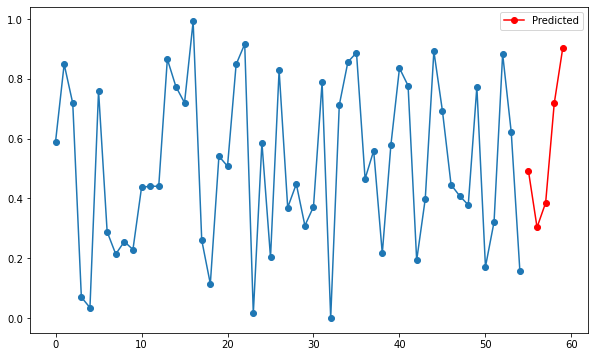


폴더에서 output_다변량_모델.csv 파일을 확인하세요

폴더에서 output_다변량_예측값.csv 파일을 확인하세요


<ipython-input-4-049de6811fb8>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped[y_val][(-test_p):] = sum(prediction.tolist(), [])


In [14]:
# PART 별 시계열 예측 다변량 (x와의 상관성 의미를 둠)
if __name__ == "__main__":
    read_model_info_file = 'input_AutoML_설정옵션6.csv' # 다변량
    output_file_name1 = 'output_다변량_모델.csv'
    output_file_name2 = 'output_다변량_예측값.csv'
    main()

## json 파일에 저장된 모델 불러오기 Test
- 생성된 모델을 재사용
- load_model_lstm() 함수사용

In [ ]:
condition = get_variables(read_condition_file) # 조건값
features, x_val, y_val, predic_period, new_generated_df, model_name, train_p, test_p = read_data_info (read_data_file, read_col_info_file, read_model_info_file, condition)
grouped, x_train, y_train, x_test, y_test, scaler = make_model_df (new_generated_df, features, y_val, predic_period, train_p, test_p, model_name)
new_RD = x_test

In [ ]:
# 단변량
sin_jsonfile = '0x00000247B44D8730.json'
sin_h5file = '0x00000247B44D8730.h5'
output_file_name = 'load_단변량_예측값.csv'
load_model_lstm(sin_jsonfile, sin_h5file, new_RD, grouped, y_val, test_p)

In [18]:
# 다변량
mul_jsonfile = '0x0000024808A3D5B0.json' # 저장된 모델  
mul_h5file = '0x0000024808A3D5B0.h5' # 저장된 모델 
output_file_name = 'load_다변량_예측값.csv'
load_model_lstm(mul_jsonfile, mul_h5file, new_RD, grouped, y_val, test_p)


폴더에서 load_다변량_예측값 파일을 확인하세요


<ipython-input-4-049de6811fb8>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped[y_val][(-test_p):] = sum(pred.tolist(), [])


,MONTH_NO,QTY,FEATURE_1_냉동,FEATURE_1_냉장,FEATURE_1_상온,FEATURE_2_B2B,FEATURE_2_B2C,FEATURE_2_미지정,FEATURE_4_O,FEATURE_4_X,FEATURE_5_A,FEATURE_5_B,FEATURE_5_C
0,2015-01-01,404.000000,0.239981,0.203638,0.533648,0.550026,0.527125,0.972182,0.647837,0.249236,0.027744,0.416673,0.639117
1,2015-02-01,257.000000,0.689120,0.519118,0.664630,0.773323,0.685176,0.043558,0.493164,0.460843,0.833957,0.606142,0.227183
2,2015-03-01,409.000000,0.392351,0.696352,0.398201,0.531463,0.132948,0.544561,0.837396,0.567844,0.162514,0.798101,0.383473
3,2015-04-01,402.000000,0.239854,0.113329,0.275443,0.458698,0.660853,0.996615,0.622213,0.519530,0.972000,0.878589,0.929494
4,2015-05-01,367.000000,0.517374,0.764316,0.079345,0.733178,0.177944,0.336866,0.556666,0.463602,0.788146,0.620782,0.436380
5,2015-06-01,493.000000,0.756848,0.362955,0.108317,0.903801,0.236986,0.448152,0.899149,0.911309,0.429942,0.641186,0.034236
6,2015-07-01,368.000000,0.069725,0.150498,0.207509,0.388624,0.422043,0.561417,0.987746,0.014615,0.184985,0.833104,0.109311
7,2015-08-01,490.000000,0.233668,0.847947,0.504744,0.028113,0.309114,0.953769,0.363063,0.017199,0.620715,0.964365,0.569018
8,2015-09-01,389.000000,0.638059,0.728979,0.605655,0.822456,0.781520,0.212548,0.077975,0.536258,0.780158,0.558851,0.354337
9,2015-10-01,316.000000,0.386249,0.756519,0.701683,0.408594,0.261450,0.696938,0.724161,0.868756,0.520856,0.060879,0.727726
